In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")

In [3]:
train_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [4]:
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")

In [5]:
test_data

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [6]:
# --- STEP 2: PREPROCESSING ---
# 1. Feature selection: Starting with core candidate features
features = ["Pclass", "Sex", "SibSp", "Parch", "Age", "Cabin"]

In [7]:
# 2. Simplify 'Cabin': Extract Deck letters to reduce noise
train_data['Cabin'] = train_data['Cabin'].apply(lambda x: str(x)[0] if pd.notnull(x) else 'U')
test_data['Cabin'] = test_data['Cabin'].apply(lambda x: str(x)[0] if pd.notnull(x) else 'U')

In [8]:
for col in train_data.columns:
    count = train_data[col].isnull().sum()
    if count > 0:
        print(f"Feature '{col}' has {count} missing values.")

Feature 'Age' has 177 missing values.
Feature 'Embarked' has 2 missing values.


In [9]:
# 3. Handle Missing Values: Use training median for Age
age_median = train_data['Age'].median()
train_data['Age'] = train_data['Age'].fillna(age_median)
test_data['Age'] = test_data['Age'].fillna(age_median)

In [10]:
for col in train_data.columns:
    count = train_data[col].isnull().sum()
    if count > 0:
        print(f"Feature '{col}' has {count} missing values.")

Feature 'Embarked' has 2 missing values.


In [11]:
# 4. Convert Strings to Numbers: One-Hot Encoding
y = train_data["Survived"]
X = pd.get_dummies(train_data[features])
X_competition_test = pd.get_dummies(test_data[features])

In [12]:
# 5. Column Alignment: Fix the ValueError for mismatched Cabin categories
X_competition_test = X_competition_test.reindex(columns=X.columns, fill_value=0)

In [13]:
# --- STEP 3: TRAIN-TEST SPLIT FOR VALIDATION ---
# Split 80% for training and 20% for local validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1234)

In [14]:
# --- STEP 4: FEATURE PRUNING (THRESHOLDING) ---
# Initial training to find low-impact features
initial_model = RandomForestClassifier(n_estimators=500, max_depth=5, random_state=1234)
initial_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_estimators=500, random_state=1234)

In [15]:
# Identify features with > 1% importance (0.01 threshold)
threshold = 0.01
importances = initial_model.feature_importances_
important_features = X.columns[importances > threshold]

In [16]:
# Filter all datasets to keep only high-signal features
X_train_final = X_train[important_features]
X_val_final = X_val[important_features]
X_test_final = X_competition_test[important_features]

In [17]:
print(f"Final features used: {list(important_features)}")

Final features used: ['Pclass', 'SibSp', 'Parch', 'Age', 'Sex_female', 'Sex_male', 'Cabin_B', 'Cabin_D', 'Cabin_E', 'Cabin_U']


In [18]:
# --- STEP 5: FINAL TRAINING & VALIDATION ---
# Train the refined model
model = RandomForestClassifier(n_estimators=500, max_depth=5, random_state=1234)
model.fit(X_train_final, y_train)

RandomForestClassifier(max_depth=5, n_estimators=500, random_state=1234)

In [19]:
# Calculate Accuracy
val_predictions = model.predict(X_val_final)
accuracy = accuracy_score(y_val, val_predictions)

print(f"\n--- Model Results ---")
print(f"Validation Accuracy: {accuracy * 100:.2f}%")


--- Model Results ---
Validation Accuracy: 86.59%


/tmp/ipykernel_17/3262595495.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


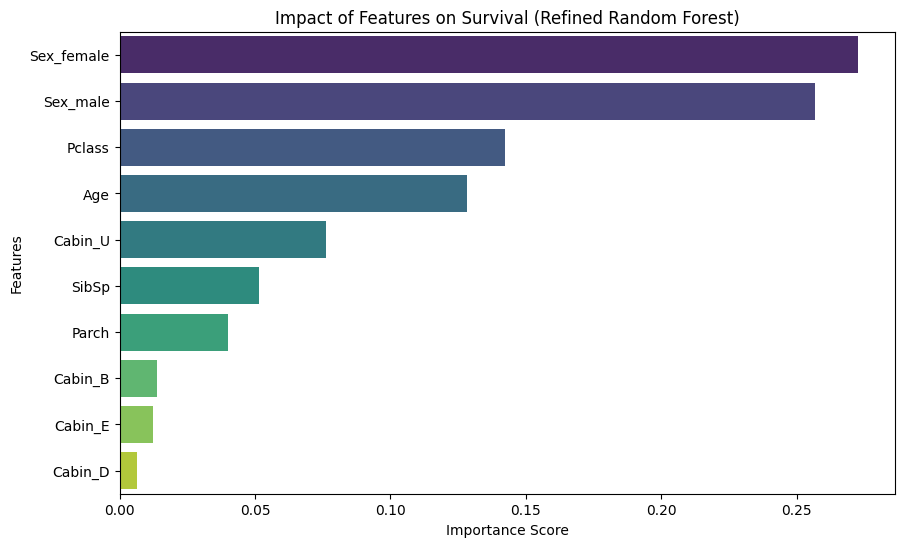

      Feature  Importance
4  Sex_female    0.272483
5    Sex_male    0.256660
0      Pclass    0.142475
3         Age    0.128297
9     Cabin_U    0.076159
1       SibSp    0.051596
2       Parch    0.039909
6     Cabin_B    0.013664
8     Cabin_E    0.012230
7     Cabin_D    0.006526


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Get feature importance from the FINAL trained model
importances = model.feature_importances_
# Use the columns from the filtered data, not the original X
feature_names = X_train_final.columns 

# 2. Create a DataFrame for easier plotting
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 3. Plot the data
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Impact of Features on Survival (Refined Random Forest)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

print(feature_importance_df)

In [21]:
# --- STEP 6: CREATE SUBMISSION ---
# Predict on the competition test data
final_predictions = model.predict(X_test_final)

In [22]:
final_predictions

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [23]:
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': final_predictions})
output.to_csv('submission.csv', index=False)
print("My second submission, saved")

My second submission, saved
